# ОИАД. Лабораторная работа №4

Используйте набор данных **datasets/famcs_students.csv**

binary_cols = [ss, interest, weekend_study, bad_sleep, glasses, anime, study_form, literature]

Исползуйте целевую переменную $y=$ binary_cols[N % 8], где $N$ - номер в списке группы. Остальные переменные используйте в качестве признаков $X$ (предикторов). Вы можете отобрать наиболее информативные (по вашему экспертному мнению) признаки, но не менее 5.

Необходимо построить несколько моделей бинарной классификации $y$ по признакам $X$.

Разделите случайно исходные данные на 3 выборки:
* тренировочная (70%) - для определения параметров модели
* валидацонная (15%) - для подбора гиперпараметров модели
* тестовую (15%) - итоговая оценка качества

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

df = pd.read_csv('../datasets/famcs_students.csv')

N = 18
binary_cols = ['ss', 'interest', 'weekend_study', 'bad_sleep', 'glasses', 'anime', 'study_form', 'literature']

In [2]:
df.head()

,cource,group,stream,sex,age,ss,interest,os,weekend_study,bad_sleep,...,social,sport,miss,study_form,foot_size,eye_color,score,retake,hostel,literature
0,4,11,Прикладная информатика,М,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Редко, легкая физкультура",3.0,Бюджет,48.0,Карие,9.2,0,"Нет, я из Минска",Да
1,4,11,Прикладная информатика,Ж,20.0,Нет,Программирование,MacOS,Нет,Нет,...,Экстраверт,"Да, я спортсмен",5.0,Бюджет,39.0,Зеленые,8.8,0,"Нет, я из Минска",Да
2,4,11,Прикладная информатика,Ж,19.0,Нет,Программирование,MacOS,Да,Нет,...,Экстраверт,Вообще нет,10.0,Бюджет,41.0,Карие,8.8,0,"Нет, я из Минска",Да
3,4,11,Прикладная информатика,Ж,20.0,Нет,Математика,MacOS,Да,Да,...,Экстраверт,"Да, я спортсмен",3.0,Бюджет,36.0,Карие,8.8,0,"Нет, я из Минска",Да
4,4,11,Прикладная информатика,М,20.0,Нет,Математика,Windows,Да,Нет,...,Интроверт,Вообще нет,1.0,Бюджет,46.0,Зеленые,9.0,0,"Нет, я из Минска",Да


In [3]:
df.columns

Index(['cource', 'group', 'stream', 'sex', 'age', 'ss', 'interest', 'os',
       'weekend_study', 'bad_sleep', 'glasses', 'work_experience', 'ai',
       'height', 'anime', 'social', 'sport', 'miss', 'study_form', 'foot_size',
       'eye_color', 'score', 'retake', 'hostel', 'literature'],
      dtype='object')

In [4]:
target_col = binary_cols[N % 8]

target_col

'weekend_study'

In [5]:
y = df[target_col]
X = df.drop(columns=target_col)

# selected_features = ['cource', 'bad_sleep', 'sex', 'social', 'hostel', 'score', 'anime', 'miss']
selected_features = ['cource', 'bad_sleep', 'sex', 'score', 'anime', 'miss']
X = X[selected_features]

y = (y == 'Да').astype(int)
X['bad_sleep'] = (X['bad_sleep'] == 'Да').astype(int)
X['sex'] = (X['sex'] == 'М').astype(int)
X['anime'] = (X['anime'] == 'Да').astype(int)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.15/(0.7+0.15), random_state=42)


## 0. Тривиальный классификатор
Всегда выдает наиболее частый класс

In [6]:
from collections import Counter

class TrivialClassifier:
    def fit(self, y):
        self.most_common_class = Counter(y).most_common(1)[0][0]

    def predict(self, X):
        return np.full(len(X), self.most_common_class)

trivial_model = TrivialClassifier()
trivial_model.fit(y_train)
y_pred_trivial = trivial_model.predict(X_test)

print("Trivial Classifier Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_trivial))
print("Precision:", precision_score(y_test, y_pred_trivial, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_trivial, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_trivial))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_trivial))

Trivial Classifier Metrics:
Accuracy: 0.9
Precision: 0.9
Recall: 1.0
ROC-AUC: 0.5
Confusion Matrix:
 [[ 0  2]
 [ 0 18]]


## 1. Наивный байесовский классификатор

In [7]:
class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.mean = {}
        self.var = {}
        self.priors = {}

        for cls in self.classes:
            X_cls = X[y == cls]
            self.mean[cls] = X_cls.mean(axis=0)
            self.var[cls] = X_cls.var(axis=0) + 1e-6
            self.priors[cls] = len(X_cls) / len(X)

    def _pdf(self, x, mean, var):
        return (1 / np.sqrt(2 * np.pi * var)) * np.exp(-0.5 * ((x - mean) ** 2) / var)

    def predict(self, X):
        predictions = []
        for _, row in X.iterrows():
            posteriors = []
            for cls in self.classes:
                prior = np.log(self.priors[cls])
                likelihood = np.sum(np.log(self._pdf(row, self.mean[cls], self.var[cls])))
                posterior = prior + likelihood
                posteriors.append(posterior)
            predictions.append(self.classes[np.argmax(posteriors)])
        return np.array(predictions)

nb_model = NaiveBayes()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

print("Naive Bayes Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_nb, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_nb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_nb))

Naive Bayes Metrics:
Accuracy: 0.15
Precision: 1.0
Recall: 0.05555555555555555
ROC-AUC: 0.5277777777777778
Confusion Matrix:
 [[ 2  0]
 [17  1]]


/Users/kovalmn/temp/oiad-3-2025/.venv/lib/python3.14/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## 2. Метод k-ближайших соседей
Алгоритм реализуйте сами!
Подберите оптимальный гиперпараметр $k$.

In [8]:
from scipy.spatial.distance import cdist

class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X, y):
        self.X_train = X.values
        self.y_train = y.values

    def predict(self, X):
        distances = cdist(X.values, self.X_train)
        k_indices = np.argpartition(distances, self.k, axis=1)[:, :self.k]
        k_nearest_labels = self.y_train[k_indices]
        predictions = [np.bincount(labels).argmax() for labels in k_nearest_labels]
        return np.array(predictions)

best_k = 1
best_f1 = 0
for k in range(1, 21):
    knn = KNN(k=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_val)
    f1 = 2 * precision_score(y_val, y_pred_knn, zero_division=0) * recall_score(y_val, y_pred_knn, zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

knn_model = KNN(k=best_k)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print(f"KNN Metrics (k={best_k}):")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_knn, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, y_pred_knn))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_knn))

KNN Metrics (k=11):
Accuracy: 0.9
Precision: 0.9444444444444444
Recall: 0.9444444444444444
ROC-AUC: 0.7222222222222222
Confusion Matrix:
 [[ 1  1]
 [ 1 17]]


## 3. Логистическая регрессия
Изобразите график зависимости метрик precision, recall от порога классификаци, а итоговый порог классификации выберите таким, при котором достигается максимум метрики f1. Используйте валидационную выборку.

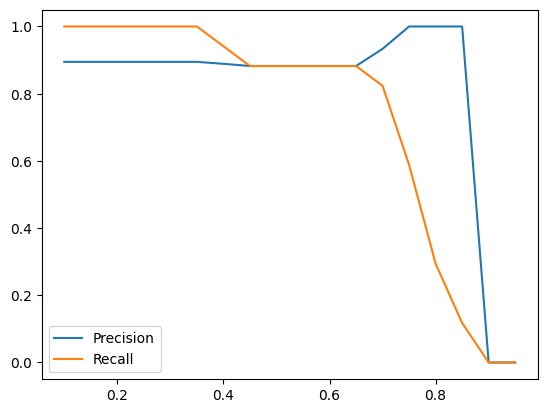

Logistic Regression Metrics (threshold=0.10):
Accuracy: 0.85
Precision: 0.8947368421052632
Recall: 0.9444444444444444
ROC-AUC: 0.6666666666666667
Confusion Matrix:
 [[ 0  2]
 [ 1 17]]


In [9]:
class LogisticRegression:
    def __init__(self, lr=0.01, n_iters=1000):
        self.lr = lr
        self.n_iters = n_iters

    def fit(self, X, y):
        self.weights = np.zeros(X.shape[1])
        self.bias = 0

        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.weights) + self.bias
            predictions = 1 / (1 + np.exp(-linear_pred))

            dw = (1 / len(X)) * np.dot(X.T, (predictions - y))
            db = (1 / len(X)) * np.sum(predictions - y)

            self.weights -= self.lr * dw
            self.bias -= self.lr * db

    def predict_proba(self, X):
        linear_pred = np.dot(X, self.weights) + self.bias
        return 1 / (1 + np.exp(-linear_pred))

    def predict(self, X, threshold=0.5):
        return (self.predict_proba(X) > threshold).astype(int)

lr_model = LogisticRegression()
lr_model.fit(X_train.values, y_train.values)
y_proba_lr = lr_model.predict_proba(X_val.values)

thresholds = np.arange(0.1, 1.0, 0.05)
f1_scores = []
precisions = []
recalls = []

for t in thresholds:
    y_pred_t = (y_proba_lr > t).astype(int)
    prec = precision_score(y_val, y_pred_t, zero_division=0)
    rec = recall_score(y_val, y_pred_t, zero_division=0)
    f1 = 2 * (prec * rec) / (prec + rec + 1e-8)
    f1_scores.append(f1)
    precisions.append(prec)
    recalls.append(rec)

best_threshold = thresholds[np.argmax(f1_scores)]

plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.legend()
plt.show()

y_pred_lr = (lr_model.predict_proba(X_test.values) > best_threshold).astype(int)

print(f"Logistic Regression Metrics (threshold={best_threshold:.2f}):")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr, zero_division=0))
print("Recall:", recall_score(y_test, y_pred_lr, zero_division=0))
print("ROC-AUC:", roc_auc_score(y_test, lr_model.predict_proba(X_test.values)))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

## 4. Оценка качества
Для каждой построенной модели, по отложенной тестовой выборке оцените качество моделей:
* accuracy
* precision
* recall
* roc-auc
* постройте матрицу ошибок

### Trivial Classifier Metrics:
- Accuracy: 0.9
- Precision: 0.9
- Recall: 1.0
- ROC-AUC: 0.5
- Confusion Matrix:
    ```
    0  2
    0 18
    ```

### Naive Bayes Metrics:
- Accuracy: 0.15
- Precision: 1.0
- Recall: 0.05555555555555555
- ROC-AUC: 0.5277777777777778
- Confusion Matrix:
    ```
    2  0
    17 1
    ```

### KNN Metrics (k=11):
- Accuracy: 0.9
- Precision: 0.9444444444444444
- Recall: 0.9444444444444444
- ROC-AUC: 0.7222222222222222
- Confusion Matrix:
    ```
    1  1
    1 17
    ```

### Logistic Regression Metrics (threshold=0.10):
- Accuracy: 0.85
- Precision: 0.8947368421052632
- Recall: 0.9444444444444444
- ROC-AUC: 0.6666666666666667
- Confusion Matrix:
    ```
    0  2
    1 17
    ```